In [1]:
import csv
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.collections import LineCollection
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sn
import statistics as stat
from collections import Counter
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
import matplotlib.ticker as ticker
import math
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.patches as patches
sn.set(style='ticks')
pd.options.mode.copy_on_write = True

In [2]:
# Description of mpl.rcParams and seetings
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
# Description of mpl.rcParams and seetings
# https://matplotlib.org/stable/tutorials/introductory/customizing.html

mpl.rcParams['figure.dpi'] = 300

mpl.rcParams['font.size'] = 9
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = "Myriad Pro"

mpl.rcParams['lines.linewidth'] = 1.0

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelweight'] = "bold"

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = "in"
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.width'] = 1.5

mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = "in"
mpl.rcParams['ytick.major.size'] = mpl.rcParams['xtick.major.size']
mpl.rcParams['ytick.major.width'] = mpl.rcParams['xtick.major.width']
mpl.rcParams['ytick.minor.width'] = mpl.rcParams['xtick.minor.width']

mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['figure.dpi'] = 300

mpl.rcParams['font.size'] = 9
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = "Myriad Pro"

mpl.rcParams['lines.linewidth'] = 1.0

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelweight'] = "bold"

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = "in"
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.width'] = 1.5

mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = "in"
mpl.rcParams['ytick.major.size'] = mpl.rcParams['xtick.major.size']
mpl.rcParams['ytick.major.width'] = mpl.rcParams['xtick.major.width']
mpl.rcParams['ytick.minor.width'] = mpl.rcParams['xtick.minor.width']

mpl.rcParams['legend.fancybox'] = True

Run this code in the same folder as the following input files (files defined below): kojakresult.txt, senserror.csv, peptideprophetresults.csv, and Dbase.txt.

Be sure to enter manual inputs in the cell below as well.

kojakresult.txt is the .kojak.txt file written when running kojak.

peptideprophetresults is the interact.pep.xml as a .csv. To generate this file, open the file in the pepXML viewer, select pick columns, ensure that columns to display include: prob, spectrum, xlink_type, kojak_score, delta_score, e-value, ppm_error, ions, peptide, protein, nprots, calc_mass, peak_area	sscan, retention_time_sec, and peak_intensity. Including any additional columns won't interfere with analysis. Then select other actions and export spreadsheet, and then save the exported spreadsheet as a csv for analysis.

senserror.csv is the error table for crosslinks. Navigate to analysis and models for the corresponding interact.pep.xml (click on a probabilty value when viewing the interact.pep.xml in the pepXML viewer in petunia), click the sens/error tables tab, change type to xl, copy from the row containing the column headings to the end of the table (do not include the row that just says "Error Table"), and paste the table into .csv document.

Dbase.txt is the search database used in the kojak search.

In [3]:
#set all manual inputs here
#Set below to be the charges that have crosslink models (each charge in the senserror.csv file)
#enter charges as strings with the + and in increasing order as in the example below
charges=["+3","+4","+5","+6"]
#enter the site of BPA incorporation as Bsite below
Bsite=9
#enter the desired FDR rate for crosslinks as a decimal value below
#a 1% FDR is indicated below
DesiredFDR=0.01
#protein is the uniprot identifier in the search database for the bpa containing protein
protein="HSPB5_B9"
#DecStr is the prefix used to indicate decoy entries in the search database
DecStr="DEC"

In [4]:
#read in files here
#any errors in this cell are likely from incorrectly naming a file or not having it in the same folder as this document
#read database file
dbase=open('Dbase.txt', "r").read()
#read in non-validated kojak results
kojaknonval = pd.read_csv(
    'kojakresult.txt', sep="\t",header=1)
#read in XL error table
probs=pd.read_csv("senserror.csv")
#read in valdiated search results
peptideprophet = pd.read_csv('peptideprophetresults.csv')

In [5]:
#filter database file to target protein
dbase=dbase.split(">")
for pro in dbase:
    if protein in pro:
        seq=pro.split("\n")
        #print(seq)
#store target protein sequence
sequence=""
for each in range(1,len(seq)):
    sequence=sequence+seq[each]
print(sequence)

MDIAIHHPBIRRPFFPFHSPSRLFDQFFGEHLLESDLFPTSTSLSPFYLRPPSFLRAPSWFDTGLSEMRLEKDRFSVNLDVKHFSPEELKVKVLGDVIEVHGKHEERQDEHGFISREFHRKYRIPADVDPLTITSSLSSDGVLTVNGPRKQVSGPERTIPITREEKPAVTAAPKK


In [6]:
#filter to only HSPB5-HSPB5 crosslinks
kojak2=kojaknonval[kojaknonval["Protein #2"].str.contains("HSPB5")]
kojak3=kojak2[kojak2["Protein #1"].str.contains("HSPB5")]
#get column numbers for needed info
xl1=kojak3.columns.get_loc("Protein #1 Site")+1
pro1=kojak3.columns.get_loc("Protein #1")+1
pep1=kojak3.columns.get_loc("Peptide #1")+1
xl2=kojak3.columns.get_loc("Protein #2 Site")+1
pep2=kojak3.columns.get_loc("Peptide #2")+1
pro2=kojak3.columns.get_loc("Protein #2")+1
psites=[]
ppep=[]
#Get crosslink site and peptide for each result in the non-valdiated search
for each in kojak3.itertuples():
    if ";" in each[pro2]:
        pros=each[pro2].split(";")
        xls=each[xl2].split(";")
        #peps=each[pep2].split(";")
        for entry in pros:
            ind=pros.index(entry)
            if protein in entry:
                indf=ind
        psites.append(xls[indf])
        ppep.append(each[pep2])
    elif each[xl1]!=str(Bsite):
        psites.append(each[xl1])
        ppep.append(each[pep1])
    elif each[xl2]!=str(Bsite):
        psites.append(each[xl2])
        ppep.append(each[pep2])
    elif each[xl1]==str(Bsite) and each[xl2]==str(Bsite):
        #This part of code includes crosslink sites to the same residue (needed if WT present with BPA protein)
        if "B" not in each[pep2]:
            print(each[pep2])
            psites.append(each[xl2])
            ppep.append(each[pep2])
        if "B" not in each[pep1]:
            print(each[pep1])
            psites.append(each[xl1])
            ppep.append(each[pep1])
#check for error in finding the crosslink site
for each in psites:
    if each == "na":
        print("error there is a crosslink to a non-target protein")
kojak3["XL Site"]=psites
kojak3["XL Peptide"]=ppep
kojak3['Possible Matches']=1
#group by scan number and sum possible matches
kjsort=kojak3.groupby(['Scan Number'], as_index=False).agg({'Possible Matches':'sum'})
#remove possible matches from kojak3
kojak3=kojak3.drop(columns=["Possible Matches"])
#merge the grouped and non-grouped version to get the number of matches from kjsort and identitites of the matches from kojak3
tots=pd.merge(left=kojak3, right=kjsort, left_on='Scan Number', right_on="Scan Number", how="right")

In [7]:
#find positions of different charges in senserror.csv
locs=[]
for each in charges:
    loc=probs[probs['Error_Rate'] == each+" only"].index[0]
    locs.append(loc)
charges = [s.strip("+") for s in charges]
#create a dictionary of senserror.csv by charge
d_probs = {}
for i in range(len(locs)):
    if i < (len(locs)-1):
        filt=probs.iloc[locs[i]:locs[i+1],:]
        filt=filt.reset_index()
    else:
        filt=probs.iloc[locs[i]:,:]
        filt=filt.reset_index()
    filt=filt.drop([0])
    d_probs[charges[i]]=filt

In [8]:
#filter to XL probs at 1%FDR
#might not need this based on cell below, but will come back to it
FDR1p=[]
FDR1c=[]
for each in d_probs:
    FDR1c.append(each)
    d_probs[each]['Error_Rate']=d_probs[each]['Error_Rate'].astype(float)
    dFDR=d_probs[each][d_probs[each]['Error_Rate'] == 0.01]
    FDR1p.append(float(dFDR["min_prob"].iloc[0]))
minprobs={}
for each in range(len(FDR1c)):
    minprobs["mincharge"+str(each+1)]=FDR1c[each]
    minprobs["minprob"+str(each+1)]=FDR1p[each]
print(minprobs)

{'mincharge1': '3', 'minprob1': 0.8038, 'mincharge2': '4', 'minprob2': 0.9587, 'mincharge3': '5', 'minprob3': 0.9389, 'mincharge4': '6', 'minprob4': 0.8904}


In [9]:
#split into crosslinked and non-crosslinked
crosslinks= peptideprophet[peptideprophet["xlink_type"].str.contains("xl")]
noncrosslinks=peptideprophet[peptideprophet["xlink_type"].str.contains("na")]
crosslinks[['protein1','protein2']]=crosslinks['protein'].str.split('+', expand=True)
crosslinks['charge']=crosslinks['spectrum'].str[-1]
scan=crosslinks.columns.get_loc("start_scan")
#create d_scans dictionary with key error rate and entry corresponding peptide prophet results
d_scans={}
d_XLpsms={}
d_Hpsms={}
d_Dpsms={}
d_Opsms={}
#get number of each protein for each error rate
#iterate over each entry in the dataframes in d_probs
for each in range(len(d_probs[str(charges[0])])):
    result0 = pd.DataFrame()
    scans=[]
    #iterate over all croslsink spectra
    for index,row in crosslinks.iterrows():
        if row["charge"] in charges:
            #filter to the correct charge entry in d_probs and store the corresponding probability value
            prob=d_probs[row["charge"]].loc[each+1,"min_prob"]
            #compare the senserror document probabilty (prob) to the peptideprophet results probability (row[probability])
            if row['probability']>=prob:
                #store results that meet the sens error probabilty cutoff
                scans.append(row.iloc[scan])
                result0=result0._append(row)
    #make pd frame rows below and add to dictionary with key being the FDR
    result0["Scan Number"]=scans
    result0["Scan Number"]=result0["Scan Number"].astype(int)
    result0['PSM']=1
    result0["peak_intensity"]=result0["peak_intensity"].replace("-",0)
    result0["peak_intensity"]=result0["peak_intensity"].astype(float)
    HSPB50=result0[result0["protein1"].str.contains(protein)]
    HSPB5=HSPB50[HSPB50["protein2"].str.contains(protein)]
    DEC0=result0[result0["protein"].str.contains(protein+","+DecStr)==False]
    DEC=DEC0[DEC0["protein"].str.contains(DecStr)]
    num_HSPB5=len(HSPB5)
    numDEC=len(DEC)
    numother=len(result0)-num_HSPB5-numDEC
    #save scans meeting requirement for each error rate
    d_scans[d_probs[str(charges[0])]["Error_Rate"][each+1]]=result0
    #save number of crosslinks per protein meeting criteria for each error rate
    d_Hpsms[(d_probs[str(charges[0])]["Error_Rate"][each+1])]=[float(d_probs[str(charges[0])]["Error_Rate"][each+1]),num_HSPB5,numDEC,numother]
#filter results to the desired FDR
validatedResults=d_scans[DesiredFDR]
#export all info for spectra that meet the desired FDR cutoff
validatedResults.to_csv('XLSpectrumMatchSummary.csv')
TXLPSMs=len(validatedResults)
print(str(TXLPSMs)+" Total XL PSMs")
#filter to crosslinks containing only the target protein
result0=validatedResults[validatedResults["protein1"].str.contains(protein)]
result0=result0[result0["protein2"].str.contains(protein)]

299 Total XL PSMs


Number PSMs by Protein at Desired FDR
       FDR  HSPB5-HSPB5  Decoy  Other
0.01  0.01        294.0    4.0    1.0


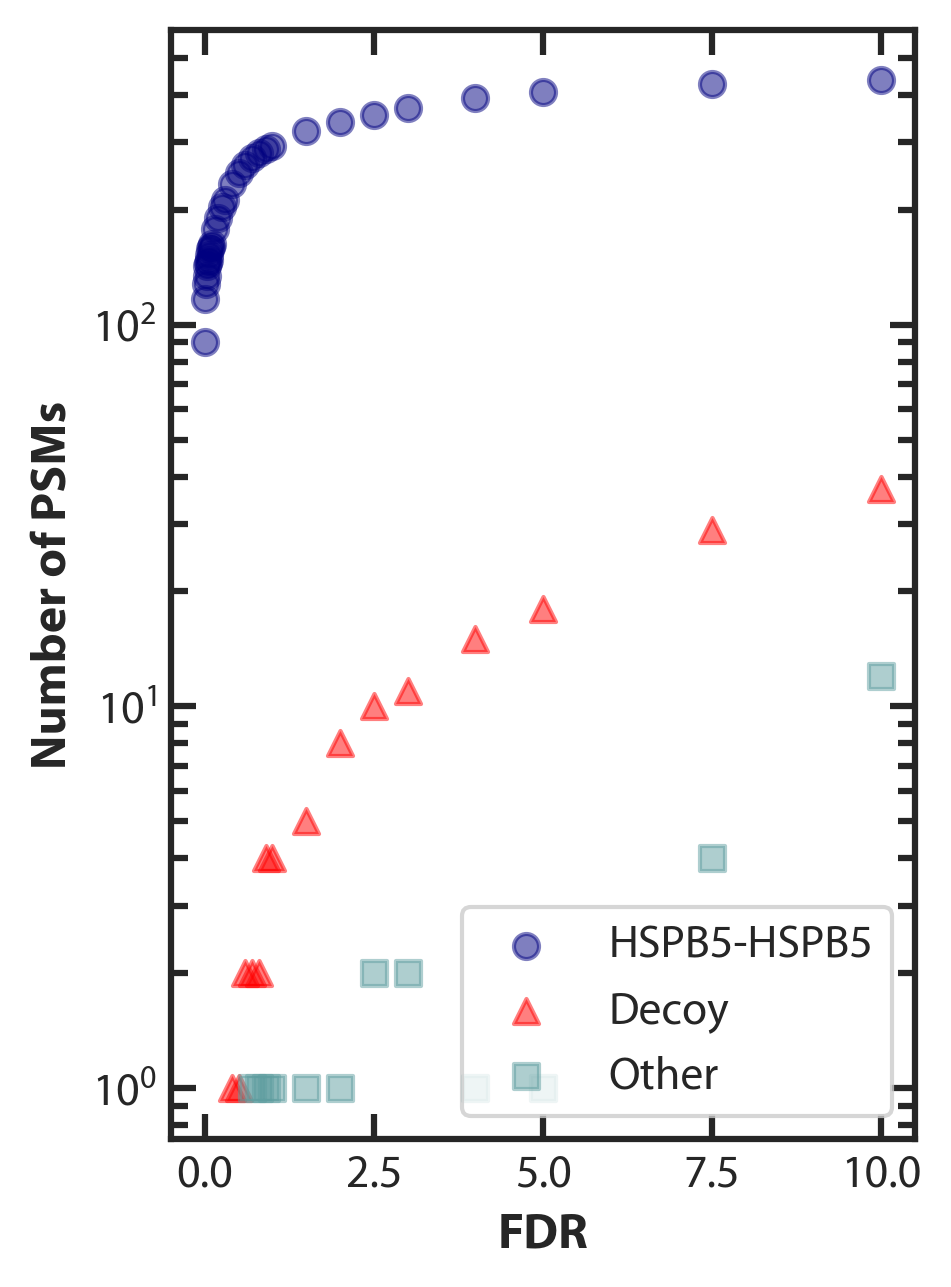

In [10]:
#plot the number of crosslinks to different protein types for each error rate
data=pd.DataFrame(d_Hpsms)
data=data.set_index([pd.Index(["FDR", "HSPB5-HSPB5", "Decoy", "Other"])])
data=data.transpose()
print("Number PSMs by Protein at Desired FDR")
print(data.loc[[0.0100]])
data["FDR%"]=data["FDR"]*100
fig, (ax1) = plt.subplots(nrows=1, ncols=1, constrained_layout=False, sharex=True)
fig.set_size_inches(3.2, 4.8)
ax1.scatter(data["FDR%"],data["HSPB5-HSPB5"],label='HSPB5-HSPB5',color="navy",alpha=0.5, marker="o")
ax1.scatter(data["FDR%"],data["Decoy"],label="Decoy",color="red",alpha=0.5,marker="^")
ax1.scatter(data["FDR%"],data["Other"],label="Other", color="cadetblue",alpha=0.5,marker="s")
ax1.legend()
ax1.set_ylabel("Number of PSMs")
plt.yscale("log")
plt.legend()
ax1.set_ylabel("Number of PSMs")
ax1.set_xlabel("FDR")
plt.savefig("FDRanalysis.pdf", bbox_inches='tight')
plt.show()

In [11]:
#merge processed kojak and peptide prophet results
result0["Scan Number"]=result0["Scan Number"].astype(int)
tots["Scan Number"]=tots["Scan Number"].astype(int)
result0=pd.merge(left=result0, right=tots, left_on='Scan Number', right_on="Scan Number", how="left")
#correct for amgiuity by divided across all pssible matches
result0['PSM']=result0["PSM"]/result0["Possible Matches"]
xlAA=[]
result0["XL Site"]=result0["XL Site"].str.split(';').str[0]
#get list of amino acids crosslinked too
for each in result0["XL Site"]:
    if sequence[int(each)-1] != "B":
        xlAA.append(sequence[int(each)-1])
    elif sequence[int(each)-1] == "B":
        xlAA.append(sequence[int(each)-1])
result0["XL Site"]=result0["XL Site"].astype(int)
result0=result0.drop(columns=["Linker Mass", "Protein #2", "Protein #1", "Peptide #2", "Peptide #1", "peptide", "protein",
                             "Linked AA #1", "Linked AA #2", "Peptide #1 Score", "Peptide #2 Score", "Protein #1 Site",
                             "Protein #2 Site", "protein1", "protein2", "ions", ])
result0['xlAA']=xlAA
result0["XL Peptide Length"]=result0["XL Peptide"].str.len()

In [12]:
#clean up result zero
result0['XL Site']=result0['XL Site'].astype(int)
result0['peak_area']=result0['peak_area'].replace("-",0)
result0['peak_area']=result0['peak_area'].astype(float)
result0['BPAsite']=Bsite
result0['BPAsite'].astype(float)
result0['XL Peptide Length']=result0["XL Peptide"].str.len()

#function to find start and end poisitions of peptides.
#Input a peptide sequence and output its starting and ending position in the sequence
def find_pep_pos(clean):
    ppos=sequence.find(clean)
    start=int(ppos)+1
    end=start+len(clean)-1
    return start, end

#group results by crosslink site 
result1=result0.groupby(['XL Site']).agg({'PSM':'sum','probability': 'mean', 'peak_area': 'sum',
                                         'BPAsite':'first',
                                         "XL Peptide":'first', "XL Peptide Length":"mean", "Possible Matches":'mean'})
result1=result1.reset_index()
print("total HSPB5 PSMs")
HXLPSMs=round(sum(result1["PSM"]))
print(HXLPSMs)

total HSPB5 PSMs
294


In [13]:
#add zero for sites with no XL PSMs before calculating rolling average
xllink=result1.columns.get_loc("XL Site")+1
links=[]
for each in result1.itertuples():
    links.append(each[xllink])
missing=[]
for interval in range(0,len(sequence),1):
    #find sites with no crosslinks
    if interval not in links:
        missing.append(interval)
#make a dataframe with values of 0 for the sites without crosslinks
nolinks=pd.DataFrame()
nolinks['XL Site']=missing
nolinks["XL Peptide Length"]=0
nolinks['PSM']=0
nolinks['probability']=0
nolinks['peak_area']=0
nolinks['protein1']=protein
nolinks['protein2']=protein
nolinks['BPAsite']=Bsite
nolinks["Possible Matches"]=0
#add together results for IDed an non-IDed sites
frames=[result1, nolinks]
result1=pd.concat(frames)
#make frequency data frame
freq=pd.DataFrame()
freq["XLsite"]=result1['XL Site'].astype(float)
freq["PSM"]=result1["PSM"]
freq["Peptide length"]=result1["XL Peptide Length"]
freq["Possible Matches"]=result1["Possible Matches"]
freq=freq.sort_values(['XLsite'])
#export site speciifc results
freq.to_csv("XLfrequency.csv")
freq.head()

,XLsite,PSM,Peptide length,Possible Matches
0,0.0,0.000000,0.0,0.000000
0,1.0,26.333333,11.0,1.375000
1,2.0,5.333333,11.0,2.090909
2,3.0,0.333333,11.0,3.000000
3,4.0,0.500000,11.0,2.000000


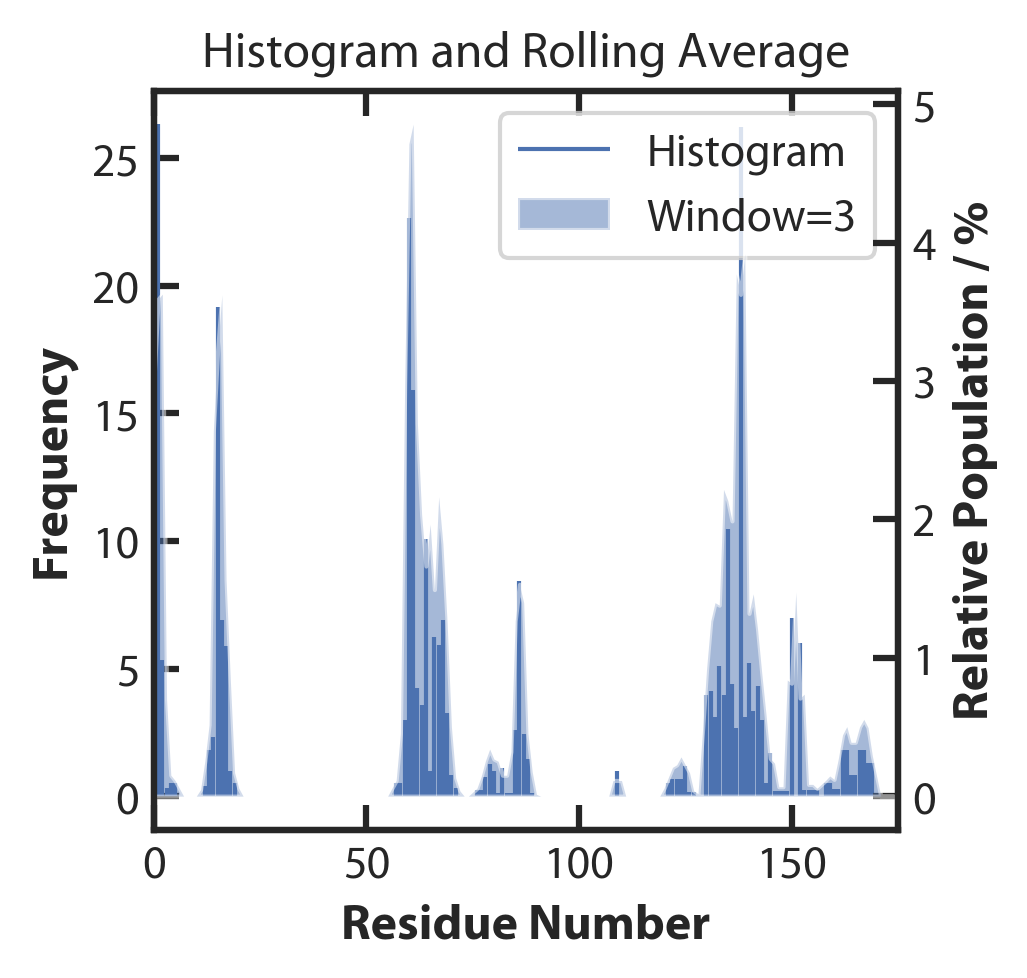

In [14]:
#plot rolling average of 3 with numlin
fig, (ax1) = plt.subplots(nrows=1, ncols=1, constrained_layout=False, sharex=True)
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig.set_size_inches(3.2, 3.2)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

ax1.vlines(freq['XLsite'],0.,freq['PSM'],label='Histogram')

ax4 = ax1.twinx() 
for i in [3]:
    rolling = moving_average(freq['PSM'],i)
    rolling *= 100./rolling.sum()
    ax4.fill_between(freq['XLsite'],0.,rolling,alpha=0.5,label="Window="+str(i))
# Add legend to hist
lines1, label1 = ax1.get_legend_handles_labels()
lines2, label2 = ax4.get_legend_handles_labels()
ax1.legend(lines1+lines2, label1+label2)
ax1.set_xlim(0,175)
ax4.set_xlim(0,175)
ax1.set_ylabel('Frequency')
ax1.set_xlabel("Residue Number")
ax4.set_ylabel('Relative Population / %')
ax1.set_title("Histogram and Rolling Average")
#export figure
plt.savefig("win3hist.pdf")
plt.show()